Initial Model - loss: 0.1155 - val_loss: 0.4484 - test_loss: 4.7467 V12

Cross Feature Model - loss: 0.2275 - val_loss: 0.8123 - test_loss: 4.4129 V13

tsfresh Model - loss: 0.2499 - val_loss: 0.9606 - test_loss: 4.4129 V14

In [1]:
# Read data and aggregate into monthly data

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(sale_cnt_month=('item_cnt_day','sum'),price_month=('item_price','mean')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')
shop_item_list = pd.unique(train_monthly_df['shop_item'])
shop_list = pd.unique(train_monthly_df['shop_id'])
item_list = pd.unique(train_monthly_df['item_id'])

print("count of shop_item:",len(shop_item_list))
print('------')
print('count of shop_id:', len(shop_list))
print('min shop_id:', min(shop_list))
print('max shop id:', max(shop_list))
print('------')
print('count item_id:', len(item_list))
print('min item_id:', min(item_list))
print('max item id:', max(item_list))
train_monthly_df

count of shop_item: 424124
------
count of shop_id: 60
min shop_id: 0
max shop id: 59
------
count item_id: 21807
min item_id: 0
max item id: 22169


,date_block_num,shop_id,item_id,sale_cnt_month,price_month,shop_item
0,0,0,32,6.0,221.0,0-32
1,0,0,33,3.0,347.0,0-33
2,0,0,35,1.0,247.0,0-35
3,0,0,43,1.0,221.0,0-43
4,0,0,51,2.0,128.5,0-51
...,...,...,...,...,...,...
1609119,33,59,22087,6.0,119.0,59-22087
1609120,33,59,22088,2.0,119.0,59-22088
1609121,33,59,22091,1.0,179.0,59-22091
1609122,33,59,22100,1.0,629.0,59-22100


In [2]:
# get the "sale_cnt sequences" of each "shop_item"
## get (data_seq_dict)

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    data_seq_dict[shop_item] = [0.0 for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])] = row['sale_cnt_month']
    
print(len(data_seq_dict))

424124


In [3]:
# get the "normalized sale_cnt sequences" and ”mean“ of each "shop_item"
## get (data_norm_seq_dict), as well as (data_norm_seq_mean_dict) and (data_norm_seq_stddev_dict)

import statistics

data_norm_seq_dict = {}
data_norm_seq_mean_dict = {}
data_norm_seq_stddev_dict = {}
for k,v in data_seq_dict.items():
    mean = statistics.mean(v)
    data_norm_seq_mean_dict[k] = mean
    stddev = statistics.stdev(v)
    data_norm_seq_stddev_dict[k] = stddev
    if stddev != 0.0:
        data_norm_seq_dict[k] = [(x-mean)/stddev for x in v]
    else:
        data_norm_seq_dict[k] = [0.0 for x in v]

print(len(data_norm_seq_dict))
print(len(data_norm_seq_mean_dict))
print(len(data_norm_seq_stddev_dict))

424124
424124
424124


In [4]:
# get the "last price" of each "shop_item" as the future price
## shopitem_price_dict

import random

shopitem_price_dict = {}  # {shop_item: [avg_price, current_max_date_block_num, cnt]}
# record price and max date_block_num of each shop_item
for _, row in train_monthly_df.iterrows():
    if row['shop_item'] not in shopitem_price_dict.keys():
        shopitem_price_dict[row['shop_item']] = [row['price_month'], row['date_block_num'], 1]
    else:
        if row['date_block_num'] > shopitem_price_dict[row['shop_item']][1]:
            shopitem_price_dict[row['shop_item']] = [row['price_month'], row['date_block_num'], 1]
        if row['date_block_num'] == shopitem_price_dict[row['shop_item']][1]:
            entry = shopitem_price_dict[row['shop_item']]
            count = entry[2] + 1
            price = (entry[0] * entry[2] + row['price_month']) / count
            shopitem_price_dict[row['shop_item']] = [price, row['date_block_num'], count]
# remove date_block_num and count in the dict to only keep [shop_item, price_month]
for k,v in shopitem_price_dict.items():
    shopitem_price_dict[k] = v[0]

# UT code: printout a random sample to check
print(len(shopitem_price_dict))
idx = random.randint(0,len(shop_item_list))
shop_item = shop_item_list[idx]
print("The last price of shop-item", shop_item, ":", shopitem_price_dict[shop_item])
shop_item = shop_item.split('-')
train_monthly_df[(train_monthly_df['shop_id']==int(shop_item[0])) &
                 (train_monthly_df['item_id']==int(shop_item[1])) &
                 (train_monthly_df['price_month']>0.0)].sort_values(by=['date_block_num'],ascending=[False])

424124
The last price of shop-item 16-15299 : 849.0


,date_block_num,shop_id,item_id,sale_cnt_month,price_month,shop_item
1028734,19,16,15299,1.0,849.0,16-15299
982933,18,16,15299,2.0,849.0,16-15299
890616,16,16,15299,1.0,849.0,16-15299
749810,13,16,15299,1.0,849.0,16-15299


In [5]:
# get the avg "sale_cnt sequences" of each "item" as default
# In case the shop_item in test dataset does not appear in training dataset, 
# we use the "item avg sale_cnt sequence" as default.
## get (item_seq_dict)

item_seq_dict = {}
item_seq_num_dict = {}
# make sum
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = [i+j for i, j in zip(item_seq_dict[item], v)]
        item_seq_num_dict[item] += 1
# make average
for item in item_seq_dict.keys():
    item_seq_dict[item] = [element / item_seq_num_dict[item] for element in item_seq_dict[item]]

print(len(item_seq_dict))

21807


In [6]:
# get the "normalized sale_cnt sequences" and "mean" of each "item"
## get (item_norm_seq_dict), as well as (item_norm_seq_mean_dict) and (item_norm_seq_stddev_dict)

import statistics

item_norm_seq_dict = {}
item_norm_seq_mean_dict = {}
item_norm_seq_stddev_dict = {}
for k,v in item_seq_dict.items():
    mean = statistics.mean(v)
    item_norm_seq_mean_dict[k] = mean
    stddev = statistics.stdev(v)
    item_norm_seq_stddev_dict[k] = stddev
    if stddev != 0:
        item_norm_seq_dict[k] = [(x-mean)/stddev for x in v]
    else:
        item_norm_seq_dict[k] = [0.0 for x in v]

print(len(item_norm_seq_dict))
print(len(item_norm_seq_mean_dict))
print(len(item_norm_seq_stddev_dict))

21807
21807
21807


In [7]:
# get the "last price" of each "item" as the future price
## get (item_price_dict)

item_price_dict = {}  # {item_id: [avg_price, current_max_date_block_num, cnt]}
# record prices and max date_block_num of each item
for _, row in train_monthly_df.iterrows():
    item_id = str(row['item_id'])
    if item_id not in item_price_dict.keys():
        item_price_dict[item_id] = [row['price_month'], row['date_block_num'], 1]
    else:
        if row['date_block_num'] > item_price_dict[item_id][1]:
            item_price_dict[item_id] = [row['price_month'], row['date_block_num'], 1]
        if row['date_block_num'] == item_price_dict[item_id][1]:
            entry = item_price_dict[item_id]
            count = entry[2] + 1
            price = (entry[0] * entry[2] + row['price_month']) / count
            item_price_dict[item_id] = [price, row['date_block_num'], count]
# remove date_block_num and count in the dict to only keep [item_id, price_month]
for k,v in item_price_dict.items():
    item_price_dict[k] = v[0]
    
# UT code: printout a random sample to check
print(len(item_price_dict))
idx = random.randint(0,len(item_list))
item_id = str(item_list[idx])
print("The last price of item", item_id, ":", item_price_dict[item_id])
tmp_df = train_monthly_df[(train_monthly_df['item_id']==int(item_id))][['date_block_num', 'price_month']]
tmp_df = tmp_df[tmp_df['date_block_num']==tmp_df['date_block_num'].max()][['price_month']].mean()
print(tmp_df)

21807
The last price of item 18726 : 28.0
price_month    28.0
dtype: float64


In [8]:
# get the avg "sale_cnt sequences" of each "shop" as default
# Just for the usage in tsfresh, because the cardinality of shop_item or item_id is too large
## get (shop_seq_dict)

shop_seq_dict = {}
shop_seq_num_dict = {}
# make sum
for k, v in data_seq_dict.items():
    shop = k.split('-')[0]
    if shop not in shop_seq_dict.keys():
        shop_seq_dict[shop] = v
        shop_seq_num_dict[shop] = 1
    else:
        shop_seq_dict[shop] = [i+j for i, j in zip(shop_seq_dict[shop], v)]
        shop_seq_num_dict[shop] += 1
# make average
for shop in shop_seq_dict.keys():
    shop_seq_dict[shop] = [element / shop_seq_num_dict[shop] for element in shop_seq_dict[shop]]

print(len(shop_seq_dict))

60


In [9]:
# get the "normalized sale_cnt sequences" and "mean" of each "shop"
## get (shop_norm_seq_dict), as well as (shop_norm_seq_mean_dict) and (shop_norm_seq_stddev_dict)

import statistics

shop_norm_seq_dict = {}
shop_norm_seq_mean_dict = {}
shop_norm_seq_stddev_dict = {}
for k,v in shop_seq_dict.items():
    mean = statistics.mean(v)
    shop_norm_seq_mean_dict[k] = mean
    stddev = statistics.stdev(v)
    shop_norm_seq_stddev_dict[k] = stddev
    if stddev != 0:
        shop_norm_seq_dict[k] = [(x-mean)/stddev for x in v]
    else:
        shop_norm_seq_dict[k] = [0.0 for x in v]

print(len(shop_norm_seq_dict))
print(len(shop_norm_seq_mean_dict))
print(len(shop_norm_seq_stddev_dict))

60
60
60


In [10]:
# get the "last price" of each "shop" as the future price
## get (shop_price_dict)

shop_price_dict = {}  # {shop_id: [avg_price, current_max_date_block_num, cnt]}
# record prices and max date_block_num of each shop
for _, row in train_monthly_df.iterrows():
    shop_id = str(row['shop_id'])
    if shop_id not in shop_price_dict.keys():
        shop_price_dict[shop_id] = [row['price_month'], row['date_block_num'], 1]
    else:
        if row['date_block_num'] > shop_price_dict[shop_id][1]:
            shop_price_dict[shop_id] = [row['price_month'], row['date_block_num'], 1]
        if row['date_block_num'] == shop_price_dict[shop_id][1]:
            entry = shop_price_dict[shop_id]
            count = entry[2] + 1
            price = (entry[0] * entry[2] + row['price_month']) / count
            shop_price_dict[shop_id] = [price, row['date_block_num'], count]
# remove date_block_num and count in the dict to only keep [shop_id, price_month]
for k,v in shop_price_dict.items():
    shop_price_dict[k] = v[0]
    
# UT code: printout a random sample to check
print(len(shop_price_dict))
idx = random.randint(0,len(shop_list))
shop_id = str(shop_list[idx])
print("The last price of shop", shop_id, ":", shop_price_dict[shop_id])
tmp_df = train_monthly_df[(train_monthly_df['shop_id']==int(shop_id))][['date_block_num', 'price_month']]
tmp_df = tmp_df[tmp_df['date_block_num']==tmp_df['date_block_num'].max()][['price_month']].mean()
print(tmp_df)

60
The last price of shop 24 : 1193.999069471458
price_month    1195.582401
dtype: float64


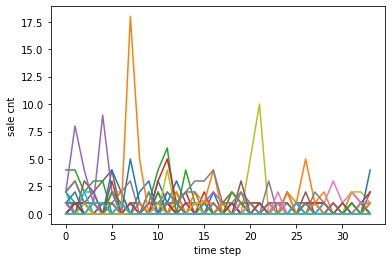

In [14]:
# plot curve

import matplotlib.pyplot as plt

random_idx_array = np.arange(len(shop_item_list))
np.random.shuffle(random_idx_array)
row_random = np.array(list(data_seq_dict.values()))[random_idx_array][0:100,:]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

In [61]:
# Data Preprocess

import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K


# parameter
ITEM_VOCAB_LEN = 1000

# Scaler of price
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.fit([[i] for i in train_monthly_df['price_month'].tolist()])

# Split X and Y
X = []
Y = []
sample_weight = []
for k,v in data_norm_seq_dict.items():
    shop_item = k
    static_vec = np.array([int(i) for i in k.split('-')])
    static_vec[1] = static_vec[1] % ITEM_VOCAB_LEN
    price_vec = price_scaler.transform([[shopitem_price_dict[k]]]).reshape((-1,))
    static_vec = np.concatenate([static_vec, price_vec])
    seq_vec = np.array(v).reshape((-1,1))  # (steps, 1)
    X.append([shop_item, static_vec, seq_vec[:-1,:]])
    Y.append(seq_vec[-1,:])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
X_train_static = np.array([x[1] for x in X_train])
X_train_seq = np.array([x[2] for x in X_train])
Y_train = np.array(Y_train)
X_val_static = np.array([x[1] for x in X_val])
X_val_seq = np.array([x[2] for x in X_val])
Y_val = np.array(Y_val)

# generate sample_weight, take mean as sample weight
for entry in X_train:
    shop_item = entry[0]
    sample_weight.append(data_norm_seq_mean_dict[shop_item])
sample_weight = np.array(sample_weight)

print("Training Dataset:")
print("\nX_train_static:")
print(X_train_static.shape)
print(X_train_static)
print("\nX_train_seq:")
print(X_train_seq.shape)
print(X_train_seq)
print("\nsample_weight:")
print(sample_weight.shape)
print(sample_weight)
print("\nY_train:")
print(Y_train.shape)
print(Y_train)
print("\nValidation Dataset:")
print("\nX_val_static:")
print(X_val_static.shape)
print(X_val_static)
print("\nX_val_seq:")
print(X_val_seq.shape)
print(X_val_seq)
print("\nY_val:")
print(Y_val.shape)
print(Y_val)

Training Dataset:

X_train_static:
(296886, 3)
[[9.00000000e+00 9.10000000e+02 2.91872934e-03]
 [5.30000000e+01 4.29000000e+02 9.70550319e-04]
 [4.40000000e+01 9.38000000e+02 1.13289857e-03]
 ...
 [2.50000000e+01 5.49000000e+02 1.62312860e-02]
 [3.00000000e+00 3.55000000e+02 1.29524682e-03]
 [1.60000000e+01 2.73000000e+02 6.45853816e-04]]

X_train_seq:
(296886, 33, 1)
[[[-0.17149859]
  [-0.17149859]
  [-0.17149859]
  ...
  [-0.17149859]
  [-0.17149859]
  [-0.17149859]]

 [[-0.17149859]
  [-0.17149859]
  [-0.17149859]
  ...
  [-0.17149859]
  [-0.17149859]
  [-0.17149859]]

 [[-0.17149859]
  [-0.17149859]
  [-0.17149859]
  ...
  [-0.17149859]
  [-0.17149859]
  [-0.17149859]]

 ...

 [[-0.26099363]
  [-0.26099363]
  [-0.26099363]
  ...
  [-0.26099363]
  [-0.26099363]
  [-0.26099363]]

 [[ 5.65945331]
  [-0.17149859]
  [-0.17149859]
  ...
  [-0.17149859]
  [-0.17149859]
  [-0.17149859]]

 [[-0.17149859]
  [-0.17149859]
  [-0.17149859]
  ...
  [-0.17149859]
  [-0.17149859]
  [-0.17149859]]]

In [62]:
# # Original Model, Wide&Deep

# # Model Parameters
# STEPS = X_train_seq.shape[1]

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error

# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# # Model
# # Wide Component
# input_static_vec = Input(name='input_static', shape = (3,))

# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
# wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])

# # Deep Component
# input_seq_vec = Input(name='input_seq', shape = (STEPS,1))

# deep_vec = LSTM(units=4, name='LSTM')(input_seq_vec)

# # Fusion Layer
# output_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, deep_vec])
# output_vec = Dense(units=1, activation='relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
#                     y=Y_train,
#                     sample_weight=sample_weight,
#                     validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

# # Original Model, train_loss: 0.1155 - val_loss: 0.4484 - test_loss: 4.7467 V12

In [63]:
# # Cross Feature Model

# # Model Parameters
# STEPS = X_train_seq.shape[1]

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization, Multiply
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error

# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# # Model
# # Wide Component
# input_static_vec = Input(name='input_static', shape = (3,))

# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
# wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])

# # Cross Feature
# shop_item_vec = Multiply()([shop_emb_vec, item_emb_vec])
# item_price_vec = Multiply()([item_emb_vec, price_vec])

# # Deep Component
# input_seq_vec = Input(name='input_seq', shape = (STEPS,1))

# deep_vec = LSTM(units=4, name='LSTM')(input_seq_vec)

# # Fusion Layer
# output_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, shop_item_vec, item_price_vec, deep_vec])
# output_vec = Dense(units=1, activation='relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
#                     y=Y_train,
#                     sample_weight=sample_weight,
#                     validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

# # Cross Feature Model - loss: 0.2275 - val_loss: 0.8123 - test_loss: 4.41291 V13

In [64]:
# tsfresh Model

# generate the tsfresh feature of shop (shop_item cardinality too large)
# Ref: https://tsfresh.readthedocs.io/en/latest/


### DATA PREPROCESS ###

from tsfresh import extract_relevant_features

# preprocess shop dataframe (take shop_id as example because cardinality of shop_item or item_id is too large)
X_shop = []
Y_shop = []
for k,v in shop_norm_seq_dict.items():
    shop_id = k
    static_vec = np.array([int(k)])
    price_vec = price_scaler.transform([[shop_price_dict[k]]]).reshape((-1,))
    static_vec = np.concatenate([static_vec, price_vec])
    seq_vec = np.array(v).reshape((-1,1))  # (steps, 1)
    X_shop.append([shop_id, static_vec, seq_vec[:-1,:]])
    Y_shop.append(seq_vec[-1,:])

    
# generate tsfresh x and y
tsfresh_x_df = pd.DataFrame(columns=['shop_id', 'date_block_num', 'sale_cnt_month'])
tsfresh_y_df = pd.DataFrame(columns=['shop_id', 'sale_cnt_month'])
for idx in range(0,len(X_shop)):
    shop_id = X_shop[idx][0]
    seq_array = np.squeeze(X_shop[idx][2])  # (33,)
    for step in range(0,len(seq_array)):
        tsfresh_x_df = tsfresh_x_df.append({'shop_id': shop_id, 'date_block_num': step, 'sale_cnt_month':seq_array[step]}, ignore_index=True)
    tsfresh_y_df = tsfresh_y_df.append({'shop_id': shop_id, 'sale_cnt_month':Y_shop[idx][0]}, ignore_index=True)
tsfresh_y_df = tsfresh_y_df.set_index('shop_id')['sale_cnt_month']


# generate tsfresh features
features_filtered = extract_relevant_features(tsfresh_x_df, tsfresh_y_df,
                                              column_id='shop_id', column_sort='date_block_num')
print("The shape of tsfresh dataframe:")
print(features_filtered.shape)  # (shop_num, feature_num)


# concat the tsfresh back to X_train
## X_train_static
tsfresh_feature_list = []
for entry in X_train_static:
    shop_id = int(entry[0])
    tsfresh_feature = features_filtered.loc[[str(shop_id)]].to_numpy()  # (1, tsfresh_num)
    tsfresh_feature_list.append(tsfresh_feature)
tsfresh_feature_array = np.concatenate(tsfresh_feature_list, axis=0)
print("The shape of X tsfresh array shape:")
print(tsfresh_feature_array.shape)  # (N, tsfresh_num)

X_train_static = np.concatenate([X_train_static, tsfresh_feature_array], axis=1)
print("The shape of X_train_static:")
print(X_train_static.shape)  # (N, static_dim+tsfresh_num)

## X_val_static
tsfresh_feature_list = []
for entry in X_val_static:
    shop_id = int(entry[0])
    tsfresh_feature = features_filtered.loc[[str(shop_id)]].to_numpy()  # (1, feature_num)
    tsfresh_feature_list.append(tsfresh_feature)
tsfresh_feature_array = np.concatenate(tsfresh_feature_list, axis=0)
print("The shape of X tsfresh array shape:")
print(tsfresh_feature_array.shape)  # (N, feature_num)

X_val_static = np.concatenate([X_val_static, tsfresh_feature_array], axis=1)
print("The shape of X_val_static:")
print(X_val_static.shape)  # (N, static_dim+tsfresh_num)


### MODEL ###

# Model Parameters
STEPS = X_train_seq.shape[1]
STATIC_LEN = X_train_static.shape[1]

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from math import log
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import feature_column
from tensorflow.nn import relu
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

# Loss
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Model
# Wide Component
input_static_vec = Input(name='input_static', shape = (STATIC_LEN,))

shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
shop_emb_vec = Flatten()(shop_emb_vec)
item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
item_emb_vec = Flatten()(item_emb_vec)
num_static_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,STATIC_LEN-2)))(input_static_vec)
wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, num_static_vec])

# Deep Component
input_seq_vec = Input(name='input_seq', shape = (STEPS,1))

deep_vec = LSTM(units=4, name='LSTM')(input_seq_vec)

# Fusion Layer
output_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, deep_vec])
output_vec = Dense(units=1, activation='relu')(output_vec)

model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
                                              verbose=1, mode='min', patience=3,
                                              restore_best_weights=True)]

history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
                    y=Y_train,
                    sample_weight=sample_weight,
                    validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
                    epochs=100, 
                    batch_size=1024*1024,
                    callbacks=callbacks)

# tsfresh Model, train_loss: 0.2499 - val_loss: 0.9606 - test_loss: 4.4129 V14

Feature Extraction: 100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


The shape of tsfresh dataframe:
(60, 184)
The shape of X tsfresh array shape:
(296886, 184)
(296886, 3)
(296886, 184)
The shape of X_train_static:
(296886, 187)
The shape of X tsfresh array shape:
(127238, 184)
The shape of X_val_static:
(127238, 187)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_static (InputLayer)       [(None, 187)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           input_static[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           input_static[0][0]               
________________________________________

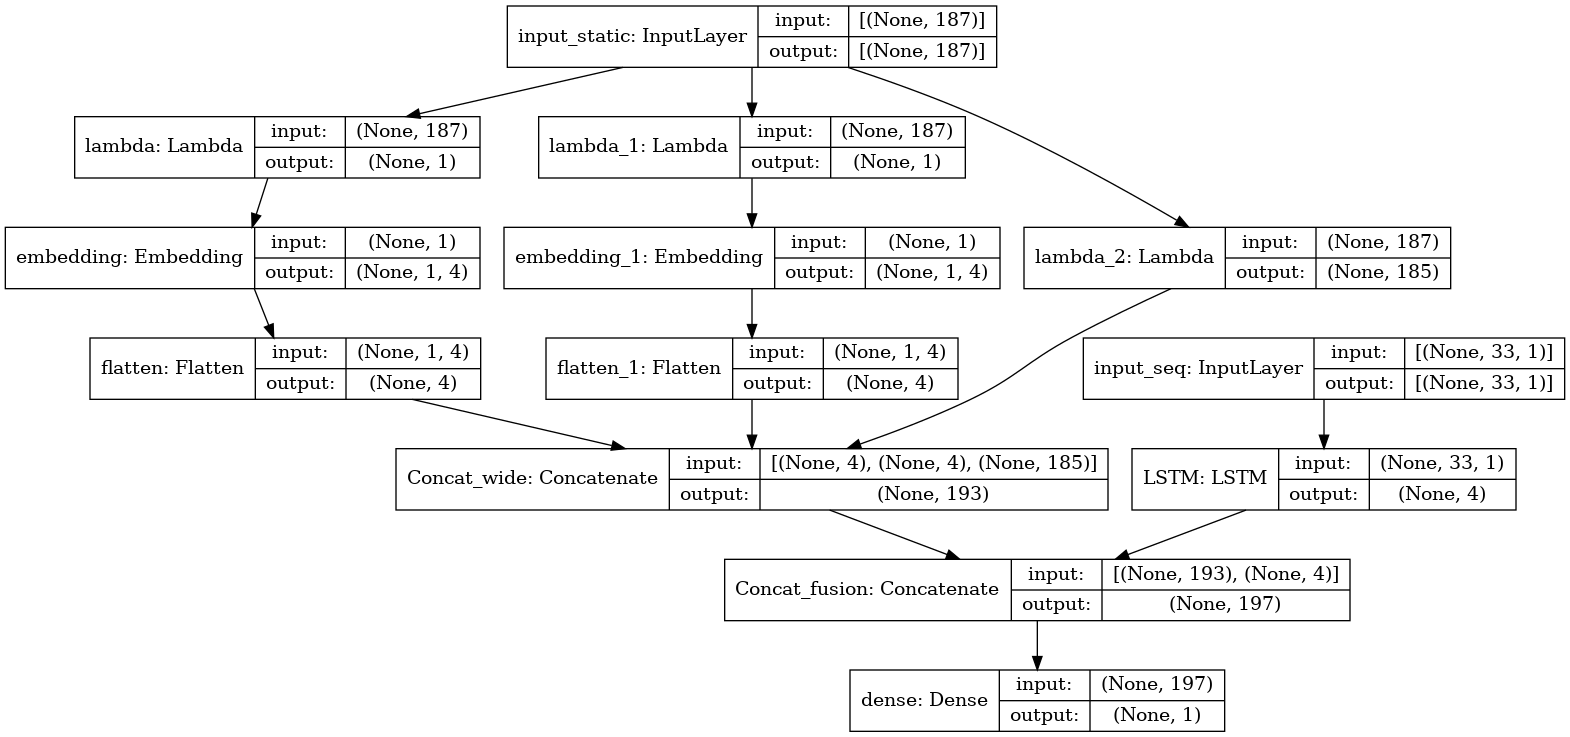

In [65]:
tf.keras.utils.plot_model(model, to_file='model_graph.png', show_shapes=True, show_layer_names=True)

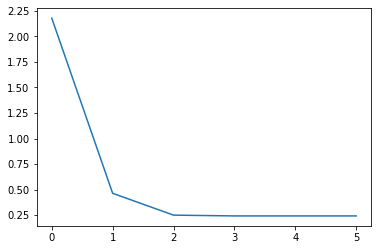

In [66]:
plt.plot(history.history['loss'])
plt.show()

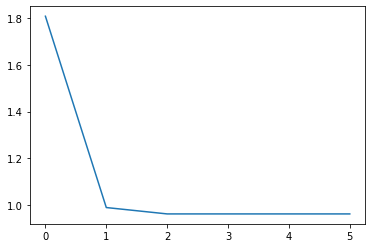

In [67]:
plt.plot(history.history['val_loss'])
plt.show()

In [68]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test_static = []
X_test_seq = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    shop_id = str(row['shop_id'])
    item_id = str(row['item_id'])
    
    # get sale_cnt_seq
    if shop_item in data_norm_seq_dict.keys():
        sale_norm_cnt_seq = data_norm_seq_dict[shop_item][1:]
    else:
        if item_id in item_norm_seq_dict.keys():
            sale_norm_cnt_seq = item_norm_seq_dict[item_id][1:]
        else:
            sale_norm_cnt_seq = [0.0 for i in range(0,STEPS)]
    
    # get price
    if shop_item in shopitem_price_dict.keys():
        price = shopitem_price_dict[shop_item]
    else:
        if item_id in item_price_dict.keys():
            price = item_price_dict[item_id]
        else:
            price = 0.0
    
    # generate the sample
    static_vec = np.array([int(shop_id), int(item_id) % ITEM_VOCAB_LEN])
    price_vec = price_scaler.transform([[price]]).reshape((-1,))
    static_vec = np.concatenate([static_vec, price_vec])
    seq_vec = np.array(sale_norm_cnt_seq).reshape((-1,1))  # (steps, 1)
    X_test_static.append(static_vec)
    X_test_seq.append(seq_vec)
X_test_static = np.array(X_test_static)
X_test_seq = np.array(X_test_seq)

## [tsfresh Model] ##
# concat tsfresh feature to X_test_static
tsfresh_feature_list = []
for entry in X_test_static:
    shop_id = int(entry[0])
    tsfresh_feature = features_filtered.loc[[str(shop_id)]].to_numpy()  # (1, tsfresh_num)
    tsfresh_feature_list.append(tsfresh_feature)
tsfresh_feature_array = np.concatenate(tsfresh_feature_list, axis=0)
print("The shape of X_test tsfresh array shape:")
print(tsfresh_feature_array.shape)  # (N, tsfresh_num)

X_test_static = np.concatenate([X_test_static, tsfresh_feature_array], axis=1)
## [tsfresh Model] ##


print('X_test_static:')
print(X_test_static.shape)
print(X_test_static)
print('\nX_test_seq:')
print(X_test_seq.shape)
print(X_test_seq)

The shape of X_test tsfresh array shape:
(214200, 184)
X_test_static:
(214200, 187)
[[ 5.00000000e+00  3.70000000e+01  2.43330807e-03 ... -5.56699102e-01
   1.99752275e+00  1.00000000e+00]
 [ 5.00000000e+00  3.20000000e+02 -2.92226853e-07 ... -5.56699102e-01
   1.99752275e+00  1.00000000e+00]
 [ 5.00000000e+00  2.33000000e+02  3.89281885e-03 ... -5.56699102e-01
   1.99752275e+00  1.00000000e+00]
 ...
 [ 4.50000000e+01  7.57000000e+02  6.45853816e-04 ... -1.02408581e+00
   9.06425957e-01  3.00000000e+00]
 [ 4.50000000e+01  6.48000000e+02  2.99727343e-04 ... -1.02408581e+00
   9.06425957e-01  3.00000000e+00]
 [ 4.50000000e+01  9.69000000e+02  1.78229158e-03 ... -1.02408581e+00
   9.06425957e-01  3.00000000e+00]]

X_test_seq:
(214200, 33, 1)
[[[-0.51728588]
  [-0.51728588]
  [-0.51728588]
  ...
  [ 3.54141874]
  [ 0.83561566]
  [-0.51728588]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[-0.36818068]
  [-0.36818068]
  [-0.36818

In [69]:
pred = model.predict({'input_static':X_test_static, 'input_seq':X_test_seq})
print(pred.shape)
print(pred)

(214200, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [70]:
# recover the prediction (de-normalized)
results = []
for i in range(0,pred.shape[0]):
    shop_id = str(test_df.iloc[i]['shop_id'])
    item_id = str(test_df.iloc[i]['item_id'])
    shop_item = shop_id + '-' + item_id
    if shop_item in data_norm_seq_dict.keys():
        mean = data_norm_seq_mean_dict[shop_item]
        stddev = data_norm_seq_stddev_dict[shop_item]
        result = pred[i][0] * stddev + mean
    else:
        if item_id in item_norm_seq_dict.keys():
            mean = item_norm_seq_mean_dict[item_id]
            stddev = item_norm_seq_stddev_dict[item_id]
            result = pred[i][0] * stddev + mean
        else:
            result = 0.0
    if result < 0.0:
        result = 0.0
    results.append(result)
results[0:10]

[0.38235294117647056,
 0.0,
 0.29411764705882354,
 0.029411764705882353,
 0.0,
 0.3235294117647059,
 0.14705882352941177,
 0.23529411764705882,
 1.8529411764705883,
 0.09536541889483066]

In [71]:
submission_df = pd.DataFrame(results, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

,item_cnt_month
ID,
0,0.382353
1,0.000000
2,0.294118
3,0.029412
4,0.000000
...,...
214195,0.264706
214196,0.029412
214197,0.205882


In [72]:
submission_df.to_csv('/kaggle/working/submission.csv')